# ***GRAPH DES DONNEES DE COMPTAGES***
> visu de données de trafic

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(r'C:\Users\martin.schoreisz\git\otv\otv\Transfert_Donnees')
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\Martin_Perso')
import pandas as pd
import geopandas as gp
import numpy as np
import altair as alt
import csv, re, os, statistics, filecmp, unidecode
from math import sqrt, pi, exp
import Connexion_Transfert as ct
import Import_trafics as it
import Outils

# **Exemple de Graph sur une df horaire de la DIRA**
> la structure attributaire est la même que celle de la Bdd

In [3]:
#donnees
dira=it.Comptage_Dira(r'Q:\DAIT\TI\DREAL33\2020\OTV\Doc_travail\Donnees_source\DIRA\0_tmja_dira_par_section_20200106.ods',
                      r'Q:\DAIT\TI\DREAL33\2020\OTV\Doc_travail\Donnees_source\DIRA\0_Annee_Complete_2019',
                     '2019')
df_horaire=dira.miseEnFormeFeuille(pd.read_excel(os.path.join(dira.dossierAnneeComplete,'Ruffec_Trimestre_1_2019.xls'),sheet_name=None),
                                 'S_MBC16.G_1','gti_otv_pg11', 'na_2010_2019_p')

In [14]:
#stats
def statsHoraires(df_horaire,attributHeure):
    ecartType=df_horaire.loc[(df_horaire['type_veh']=='VL')&(~df_horaire[attributHeure].isna())][attributHeure].std()
    moyenne=df_horaire.loc[(df_horaire['type_veh']=='VL')&(~df_horaire[attributHeure].isna())][attributHeure].mean()
    median=df_horaire.loc[(df_horaire['type_veh']=='VL')&(~df_horaire[attributHeure].isna())][attributHeure].median()
    plageMin=moyenne-2*ecartType
    plageMax=moyenne+2*ecartType
    return ecartType,moyenne,median,plageMin,plageMax
ecartType,moyenne,median,plageMin,plageMax=statsHoraires(df_horaire,'h10_11')

In [78]:
def graphTrafHoraire(df_horaire, stats, attributHeure):
    ecartType,moyenne,median,plageMin,plageMax=stats
    chartTraf=alt.Chart(df_horaire.loc[(df_horaire['type_veh']=='VL')&(~df_horaire[attributHeure].isna())][['jour',attributHeure]].
                        sort_values(attributHeure),title=attributHeure).mark_point().encode(
                x='jour',
                y=alt.Y(attributHeure+':Q',axis=alt.Axis(title='Nb de vehicule')),
                tooltip='jour').interactive()

    chartStat=alt.Chart(pd.concat([df_horaire[['jour']].assign(val=v, typeVal=t) 
                                   for v,t in ((moyenne,'moyenne'),(median,'median'))])).mark_line().encode(
        x='jour',y='val',color='typeVal')

    intervalleConf=alt.Chart(df_horaire[['jour']].assign(plageMini=plageMin, plageMaxi=plageMax)).mark_area(opacity=0.3, color='yellow').encode(
            x='jour', 
            y=alt.Y('plageMini',axis=alt.Axis(title='Nb de vehicule')),
            y2='plageMaxi')

    return intervalleConf+chartTraf+chartStat

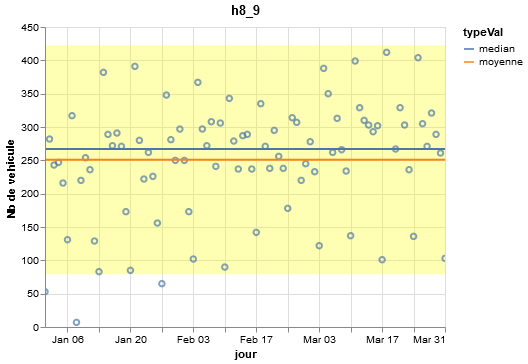

In [82]:
graphTrafHoraire(df_horaire,statsHoraires(df_horaire,'h8_9'),'h8_9')

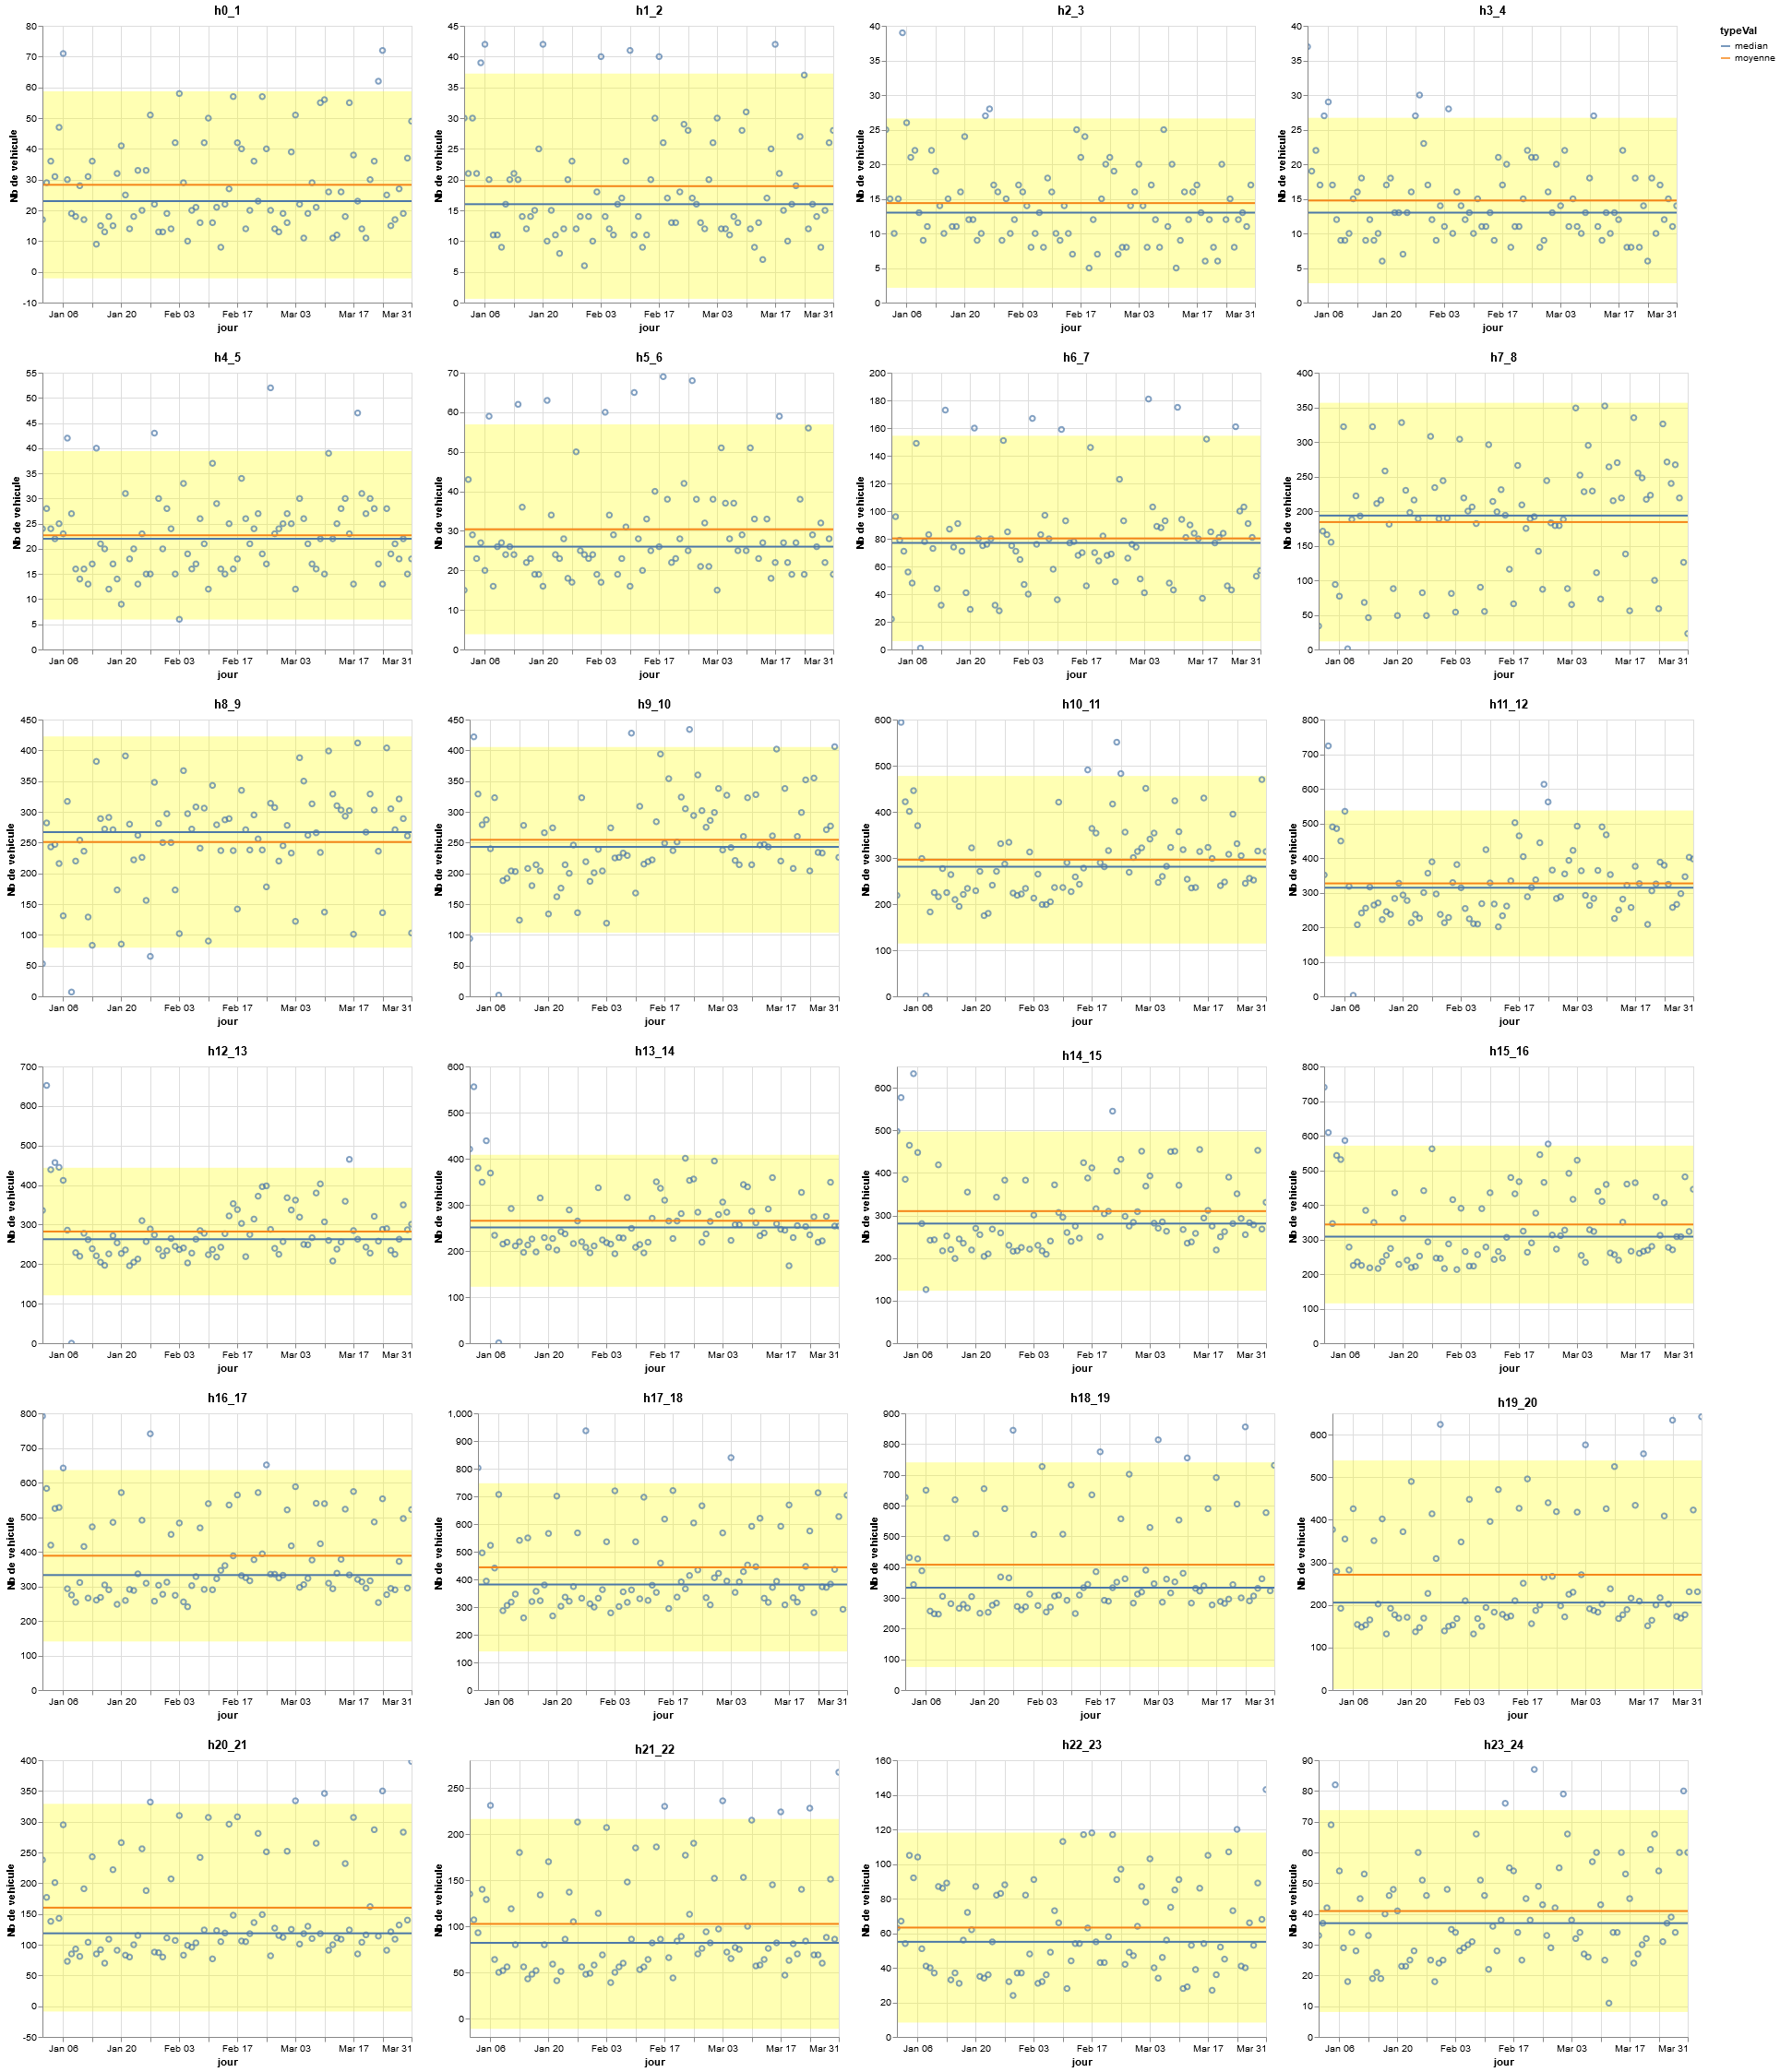

In [81]:
alt.VConcatChart(vconcat=[alt.HConcatChart(hconcat=([graphTrafHoraire(df_horaire,statsHoraires(df_horaire,attributHeure),attributHeure) 
                           for attributHeure in [f'h{i+j}_{i+j+1}' for i in range(4)]])) for j in range(0,21,4)])